In [1]:
import numpy as np
import pandas as pd

import pymysql
import dotenv
import os
import pickle
import seaborn as sns
import matplotlib

from datetime import timedelta, datetime

import matplotlib.pyplot as plt

# Normalization/Standardization
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder

from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Dropout, Conv1D, GRU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Sequential
# from tensorflow.keras.models import Sequential, save_model, load_model  # save_model, load_model은 2버전부터 models에 속함
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.saving import save_model, load_model

# 경고 무시 코드 추가
import warnings
warnings.filterwarnings('ignore')

def pltconfig_default() :
  sns.reset_defaults()
  %matplotlib inline

pltconfig_default()

matplotlib.rcParams

matplotlib.rcParams['font.family']

current_font_list = matplotlib.rcParams['font.family']

font_path = 'C:\\Windows\\Fonts\\batang.ttc'

kfont = matplotlib.font_manager.FontProperties(fname=font_path).get_name()

matplotlib.rcParams['font.family'] = [kfont] + current_font_list

In [2]:
# 모델 불러오기 테스트

lstm_load_path = f"./Models/all_data/new_data/lstm_model_stne_all"

lstm_model = load_model(lstm_load_path)

In [3]:
rnn_load_path = f"./Models/all_data/new_data/rnn_model_stne_all"

rnn_model = load_model(rnn_load_path)

In [4]:
gru_load_path = f"./Models/all_data/new_data/gru_model_stne_all"

gru_model = load_model(gru_load_path)

In [5]:
St_NotEncode_data = pd.read_pickle("StandardScalar_final_data")
  
print(St_NotEncode_data.shape)

NonNormal_data = pd.read_pickle("final_data")

print(NonNormal_data.tail())

(17422, 9)
          년   월   일  시간  강수량   풍속     풍향    습도  일조시간  일사량  적설량  전운량      시정  \
17513  2022  12  31  19  0.0  0.8  360.0  47.0   0.0  0.0  0.0  0.0  2879.0   
17514  2022  12  31  20  0.0  0.1    0.0  53.0   0.0  0.0  0.0  0.0  2823.0   
17515  2022  12  31  21  0.0  0.0    0.0  62.0   0.0  0.0  0.0  0.0  2567.0   
17516  2022  12  31  22  0.0  0.6  320.0  70.0   0.0  0.0  0.0  0.0  2047.0   
17517  2022  12  31  23  0.0  0.1    0.0  75.0   0.0  0.0  0.0  0.0  1592.0   

       지면온도  금일발전량  
17513  -1.1    0.0  
17514  -1.6    0.0  
17515  -2.3    0.0  
17516  -2.8    0.0  
17517  -3.3    0.0  


In [6]:
# Feature와 Label 분리하기
def Feature_Label(datafile) :
    X = datafile.iloc[:,:-1]
    y = datafile.iloc[:,-1]

    return X, y

print("StandardScaler Not Encode Data")
SNE_X, SNE_y = Feature_Label(St_NotEncode_data)
print(SNE_X.shape, SNE_y.shape)
SNE_X_train, SNE_X_test, SNE_y_train, SNE_y_test = train_test_split(SNE_X, SNE_y, test_size=0.2, random_state=10, shuffle=False)
print(SNE_X_train.shape, SNE_X_test.shape, SNE_y_train.shape, SNE_y_test.shape)

StandardScaler Not Encode Data
(17422, 8) (17422,)
(13937, 8) (3485, 8) (13937,) (3485,)


In [7]:
WINDOW_SIZE=3
BATCH_SIZE=28

def windowed_dataset(x, y, window_size, batch_size, shuffle) :
  ds_x = tf.data.Dataset.from_tensor_slices(x).window(window_size, stride=1, shift=1, drop_remainder=True) 
  ds_x = ds_x.flat_map(lambda x : x.batch(window_size))
  
  ds_y = tf.data.Dataset.from_tensor_slices(y[window_size:])
  
  ds = tf.data.Dataset.zip((ds_x, ds_y))
  
  if shuffle:
    ds = ds.shuffle(1000)
  
  return ds.batch(batch_size).prefetch(1)

In [8]:
train_data = windowed_dataset(SNE_X_train, SNE_y_train, WINDOW_SIZE, BATCH_SIZE, True)
train_data_ns = windowed_dataset(SNE_X_train, SNE_y_train, WINDOW_SIZE, BATCH_SIZE, False)
test_data = windowed_dataset(SNE_X_test, SNE_y_test, WINDOW_SIZE, BATCH_SIZE, False)

125/125 [==============================] - 3s 12ms/step


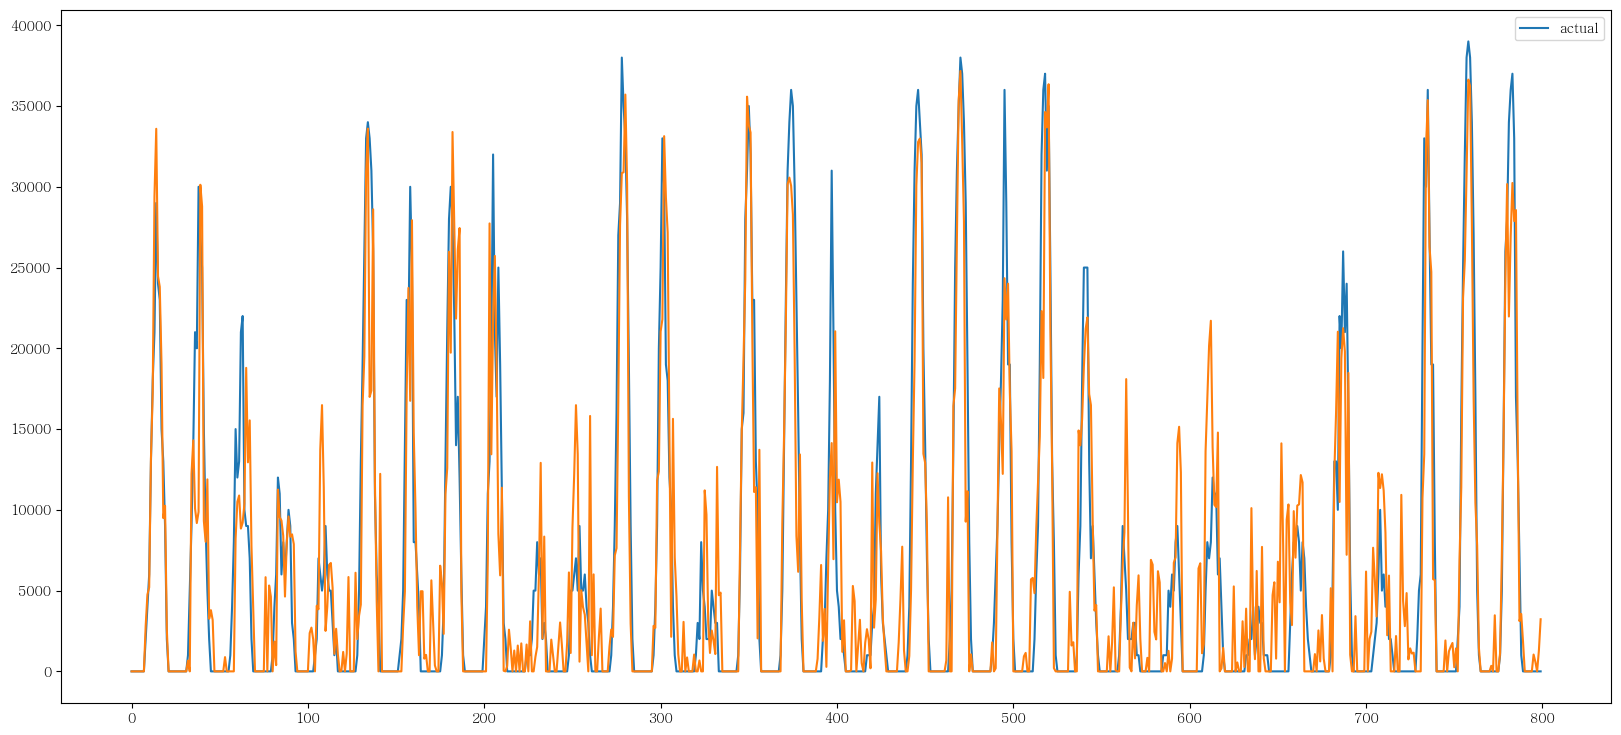

In [9]:
y_pred = lstm_model.predict(test_data)

plt.figure(figsize=(20, 9))
plt.plot(np.asarray(SNE_y_test)[WINDOW_SIZE:800+WINDOW_SIZE], label='actual')
plt.plot(y_pred[:800])
plt.legend()
plt.show()

125/125 [==============================] - 0s 1ms/step


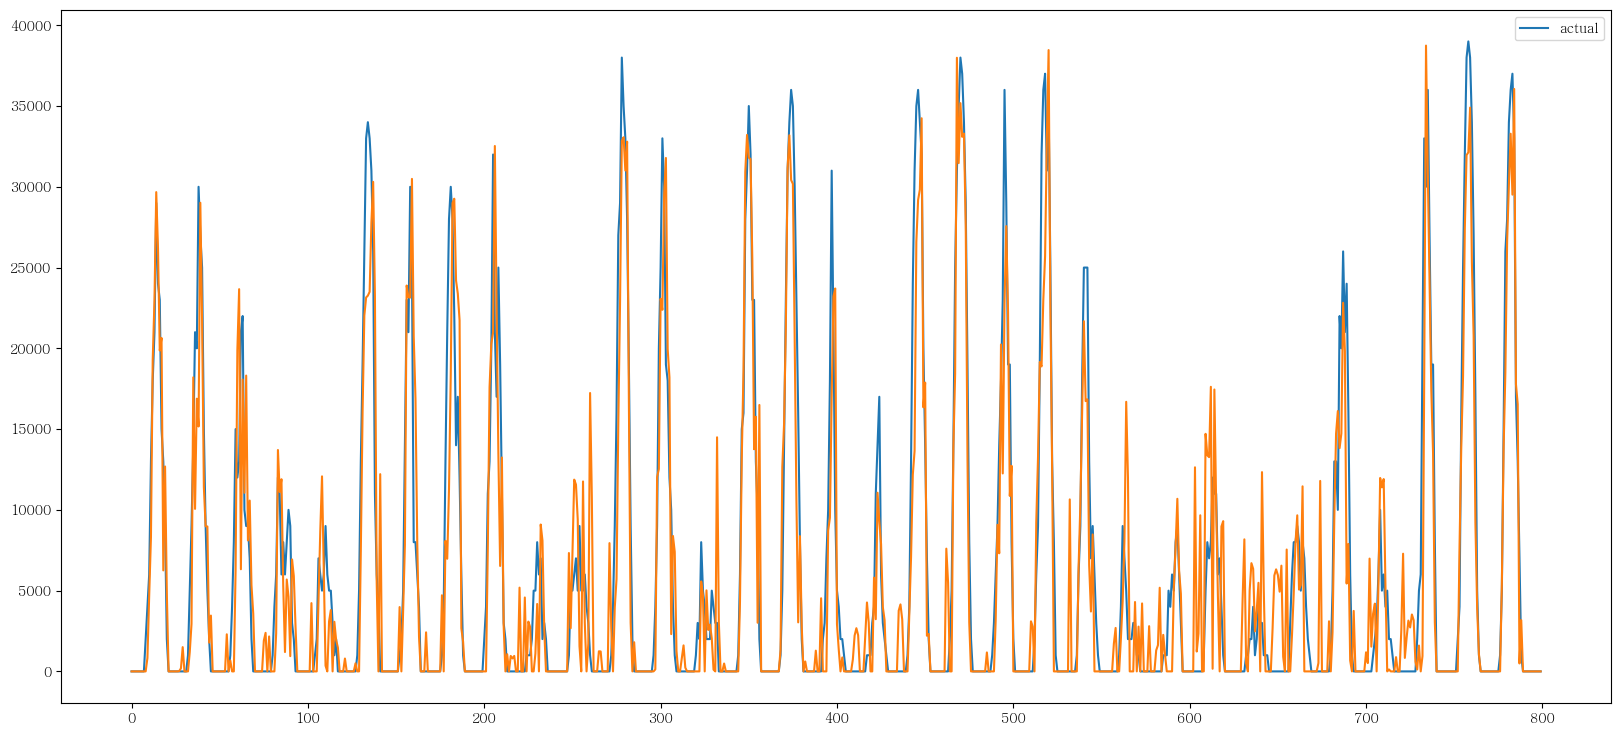

In [10]:
y_pred = rnn_model.predict(test_data)

plt.figure(figsize=(20, 9))
plt.plot(np.asarray(SNE_y_test)[WINDOW_SIZE:800+WINDOW_SIZE], label='actual')
plt.plot(y_pred[:800])
plt.legend()
plt.show()

125/125 [==============================] - 1s 2ms/step


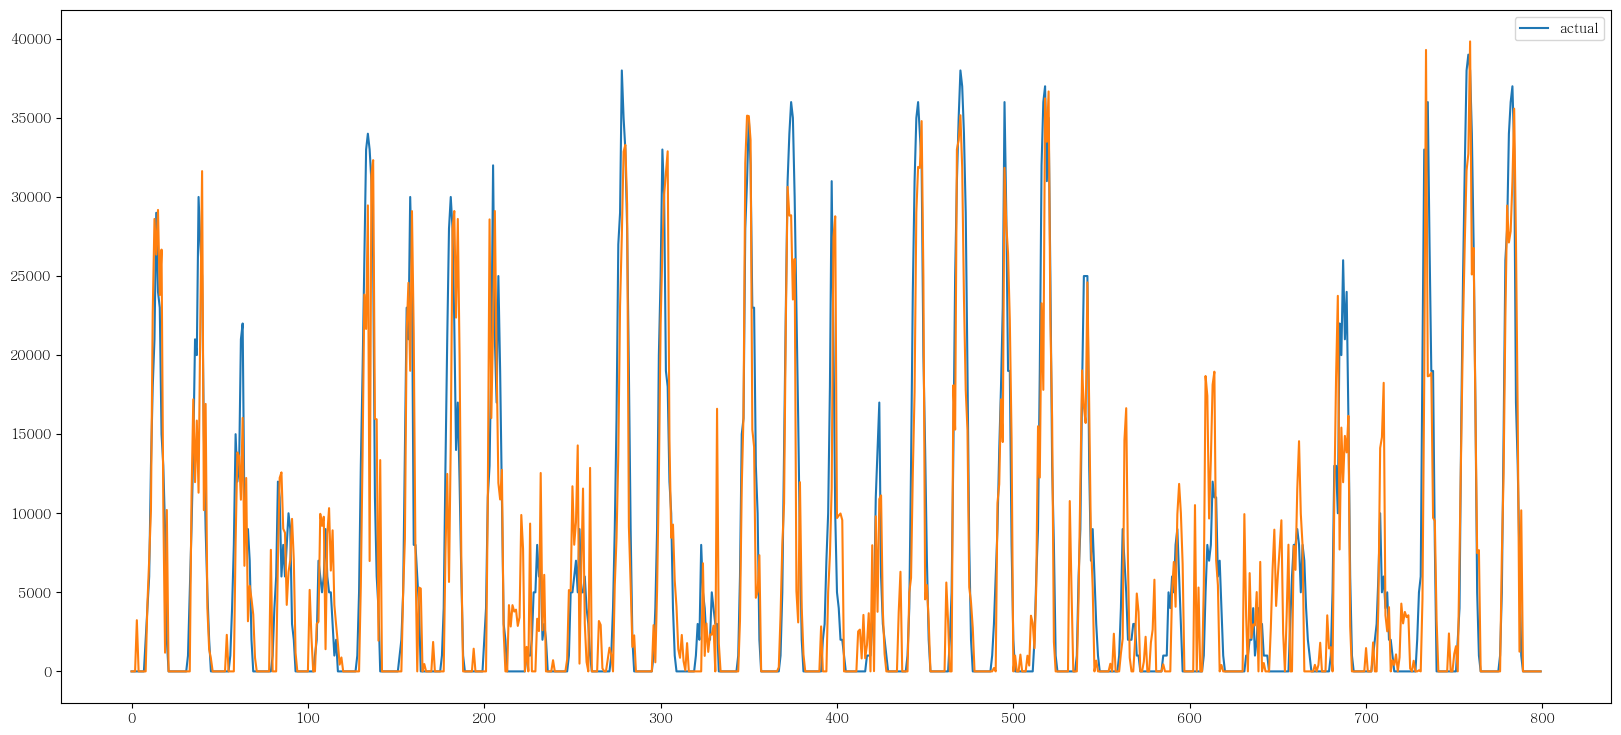

In [11]:
y_pred = gru_model.predict(test_data)

plt.figure(figsize=(20, 9))
plt.plot(np.asarray(SNE_y_test)[WINDOW_SIZE:800+WINDOW_SIZE], label='actual')
plt.plot(y_pred[:800])
plt.legend()
plt.show()

# print(SNE_y_test.shape)
# print(y_pred.shape)

In [12]:
lstm_results = lstm_model.evaluate(train_data)
rnn_results = rnn_model.evaluate(train_data)
gru_results = gru_model.evaluate(train_data)
print("===========================================================================================")
lstm_val_results = lstm_model.evaluate(test_data)
rnn_val_results = rnn_model.evaluate(test_data)
gru_val_results = gru_model.evaluate(test_data)

125/125 [==============================] - 0s 2ms/step - loss: 2512.8262 - mse: 20905918.0000 - mae: 2513.1416


In [13]:
SNE_X.tail()

,0,1,2,3,4,5,6,7
17417,-0.113529,-0.301027,1.660271,-0.660041,-0.665818,-1.235115,0.355744,-1.314612
17418,-0.113529,-1.026107,-1.060383,-0.393749,-0.665818,-1.235115,0.319175,-1.352070
17419,-0.113529,-1.129690,-1.060383,0.005688,-0.665818,-1.235115,0.152005,-1.404511
17420,-0.113529,-0.508193,1.357976,0.360744,-0.665818,-1.235115,-0.187560,-1.441969
17421,-0.113529,-1.026107,-1.060383,0.582654,-0.665818,-1.235115,-0.484680,-1.479427


In [14]:
# train_data scale과 동일하게 적용
# train_set의 scaler를 fit해서 리스트로 저장
# 새로운 데이터가 들어왔을 때 transform만 적용해 모델의 기준과 일치화

start_idx = -4580


df = NonNormal_data

# df.set_index(['년','월','일','시간'], inplace=True)
df = df.drop(['일사량', '적설량'], axis=1)

scaler = StandardScaler()
scaler.fit(df.iloc[:,4:-1])

df.reset_index(drop=True, inplace=True)

df_sample = NonNormal_data.iloc[start_idx:start_idx+3:1, :-1]   # new 데이터가 지정될 변수

# df_sample = NonNormal_data.iloc[-3:, :-1]
# df_sample.iloc[:, 4:]

df_sample = df_sample.drop(['일사량', '적설량'], axis=1)


df_scaled = pd.DataFrame(scaler.transform(df_sample.iloc[:, 4:]))
df_scaled = df_scaled.fillna(0.0)

# date_set = df.iloc[-3:,:4]
date_set = df.iloc[start_idx:start_idx+3:1,:4]

date_set.reset_index(drop=True, inplace=True)

data = pd.concat([date_set, df_scaled], axis=1)

# print(data)

# # data['년'] = data['년'].dt.year
# # data['월'] = data['월'].dt.month
# # data['일'] = data['일'].dt.day

# data['년'] = pd.to_datetime(data['년'])
# data['월'] = pd.to_datetime(data['월'])
# data['일'] = pd.to_datetime(data['일'])

# # 예측 시간 = 마지막 시간 + 1
# predict_time = data.iloc[-1,3] + 1

# df_sample
# print(df_scaled)
# print(date_set)
# print(df_sample)

data

,년,월,일,시간,0,1,2,3,4,5,6,7
0,2022,6,22,4,-0.113529,-0.818941,-1.060383,1.115238,-0.665818,-1.235115,-0.593079,0.475872
1,2022,6,22,5,-0.113529,-0.715359,-1.060383,1.115238,-0.665818,-1.235115,-0.696908,0.438415
2,2022,6,22,6,-0.113529,-1.026107,-1.060383,1.070856,-0.179684,-1.235115,-0.508188,0.468381


In [15]:
data_t = data.iloc[:, 4:].to_numpy()

test_set = data_t.reshape(1, data_t.shape[0], data_t.shape[1])

y_pred = lstm_model.predict(test_set)

# print(SNE_X_test.shape)
# print(data.iloc[:, 4:].shape)

# print(test_set)

# NonNormal_data.tail()


y_test = NonNormal_data.iloc[start_idx+3, -1]
print(y_test)
print(y_pred[0][0])
# print(y_pred)


################ 결과값 만들기 ####################

1/1 [==============================] - 1s 870ms/step
7000.0
6998.4336


In [16]:
# 기준 scaler 정의

NonNormal_data = pd.read_pickle("final_data")

print(NonNormal_data.tail())

df = NonNormal_data

# df.set_index(['년','월','일','시간'], inplace=True)
df = df.drop(['일사량', '적설량'], axis=1)

scaler = StandardScaler()
scaler.fit(df.iloc[:,4:-1])

df.reset_index(drop=True, inplace=True)

with open('scaler.pkl', 'wb') as f :
    pickle.dump(scaler, f)

          년   월   일  시간  강수량   풍속     풍향    습도  일조시간  일사량  적설량  전운량      시정  \
17513  2022  12  31  19  0.0  0.8  360.0  47.0   0.0  0.0  0.0  0.0  2879.0   
17514  2022  12  31  20  0.0  0.1    0.0  53.0   0.0  0.0  0.0  0.0  2823.0   
17515  2022  12  31  21  0.0  0.0    0.0  62.0   0.0  0.0  0.0  0.0  2567.0   
17516  2022  12  31  22  0.0  0.6  320.0  70.0   0.0  0.0  0.0  0.0  2047.0   
17517  2022  12  31  23  0.0  0.1    0.0  75.0   0.0  0.0  0.0  0.0  1592.0   

       지면온도  금일발전량  
17513  -1.1    0.0  
17514  -1.6    0.0  
17515  -2.3    0.0  
17516  -2.8    0.0  
17517  -3.3    0.0  


In [17]:
# 샘플 데이터 만들기 (기상청 예보데이터 가정)
filter_forecast_1 = (df['년'] == 2022) & (df['월'] == 12) & (df['일'] == 29) & (df['시간'] > 20)
filter_forecast_2 = (df['년'] == 2022) & (df['월'] == 12) & (df['일'] == 30)

sample_df = pd.concat([df[filter_forecast_1], df[filter_forecast_2]], axis=0)

result_df = sample_df.iloc[3:, -1]
sample_df = sample_df.iloc[:,:-1]   # 금일 발전량 제외


# print(sample_df)
print(result_df)

with open('sample_data', 'wb') as f :
    pickle.dump(sample_df, f)

with open('result_data', 'wb') as f :
    pickle.dump(result_df, f)

17374        0.0
17375        0.0
17376        0.0
17377        0.0
17378        0.0
17379        0.0
17380        0.0
17381        0.0
17382     5000.0
17383    14000.0
17384    22000.0
17385    26000.0
17386    30000.0
17387    30000.0
17388    26000.0
17389    15000.0
17390     5000.0
17391        0.0
17392        0.0
17393        0.0
17394        0.0
17395        0.0
17396        0.0
17397        0.0
Name: 금일발전량, dtype: float64


In [39]:
NonNormal_data = pd.read_pickle("final_data")

# print(NonNormal_data)

def make_sample(df, year, month, day) :
  
  if '일사량' in df and '적설량' in df :
    df = df.drop(['일사량', '적설량'], axis=1)
  
  filter_forecast_1 = (df['년'] == year) & (df['월'] == month) & (df['일'] == day-1) & (df['시간'] > 20)
  filter_forecast_2 = (df['년'] == year) & (df['월'] == month) & (df['일'] == day)

  sample_df = pd.concat([df[filter_forecast_1], df[filter_forecast_2]], axis=0)

  result_df = sample_df.iloc[3:, -1]
  sample_df = sample_df.iloc[:,:-1]   # 금일 발전량 제외


  print(sample_df)
  print(result_df)

  with open(f'sample_data_{year}{month}{day}', 'wb') as f :
      pickle.dump(sample_df, f)

  with open(f'result_data_{year}{month}{day}', 'wb') as f :
      pickle.dump(result_df, f)

  return sample_df, result_df

test_data = make_sample(NonNormal_data, 2022, 10, 13)

print(test_data)

          년   월   일  시간  강수량   풍속     풍향    습도  일조시간   전운량      시정  지면온도
15595  2022  10  12  21  0.0  0.4    0.0  74.0   0.0   0.0  4637.0  14.0
15596  2022  10  12  22  0.0  0.0    0.0  80.0   0.0   1.0  4007.0  12.9
15597  2022  10  12  23  0.0  0.3    0.0  85.0   0.0   1.0  3705.0  12.0
15598  2022  10  13   0  0.0  0.1    0.0  85.0   0.0   7.0  3952.0  12.4
15599  2022  10  13   1  0.0  0.1    0.0  87.0   0.0   0.0  3628.0  11.4
15600  2022  10  13   2  0.0  0.0    0.0  88.0   0.0   0.0  3487.0  10.6
15601  2022  10  13   3  0.0  0.0    0.0  88.0   0.0  10.0  3613.0  10.9
15602  2022  10  13   4  0.0  0.5   50.0  88.0   0.0   9.0  3463.0  10.9
15603  2022  10  13   5  0.0  0.2    0.0  90.0   0.0   9.0  3432.0   9.6
15604  2022  10  13   6  0.0  0.1    0.0  91.0   0.0  10.0  2855.0   9.1
15605  2022  10  13   7  0.0  0.1    0.0  91.0   0.6   9.0  2704.0   9.2
15606  2022  10  13   8  0.0  0.3    0.0  81.0   1.0   2.0  2884.0  13.0
15607  2022  10  13   9  0.0  0.1    0.0  63.0   1.

In [20]:
with open('scaler.pkl', 'rb') as f :
    scaler = pickle.load(f)

with open('sample_data', 'rb') as f :
    sample_data = pickle.load(f)
    
with open('result_data', 'rb') as f :
    result_data = pickle.load(f)


def data_trans(data_set, scaler, model) :
    predict_result = []

    row_idx = data_set.shape[0]
    print(row_idx)

    df_scaled = pd.DataFrame(scaler.transform(data_set.iloc[:, 4:]))
    df_scaled = df_scaled.fillna(0.0)

    date_set = data_set.iloc[:, :4]
    date_set.reset_index(drop=True, inplace=True)

    data = pd.concat([date_set, df_scaled], axis=1)


    for i in range(row_idx-3):
        data_t = data.iloc[i:i+3:1, 4:].to_numpy()
        test_set = data_t.reshape(1, data_t.shape[0], data_t.shape[1])
        y_pred = model.predict(test_set)   
        predict_result.append(y_pred)

    return predict_result


# pred_data = data_trans(sample_data, scaler, lstm_model)

# print(data_trans(sample_data, scaler, lstm_model))


27
1/1 [==============================] - 0s 14ms/step
[[0.10549164]]
[[0.07075596]]
[[0.09078789]]
[[0.05989647]]
[[0.12925434]]
[[0.14978123]]
[[0.12891483]]
[[0.08054829]]
[[0.06429958]]
[[14606.844]]
[[23580.668]]
[[23744.693]]
[[23741.934]]
[[21154.824]]
[[17356.77]]
[[13825.5]]
[[2659.4907]]
[[0.08157635]]
[[0.08342552]]
[[0.08120441]]
[[0.08080196]]
[[0.08160305]]
[[0.06874752]]
[[0.10400486]]


In [42]:
with open('scaler.pkl', 'rb') as f :
    scaler = pickle.load(f)

with open('sample_data_20221013', 'rb') as f :
    sample_data = pickle.load(f)
    
with open('result_data_20221013', 'rb') as f :
    result_data = pickle.load(f)

pred_data = data_trans(sample_data, scaler, lstm_model)

# pred_data = [x[0] for x in pred_data]
# result_data.reset_index(drop=True, inplace=True)

27
1/1 [==============================] - 0s 14ms/step


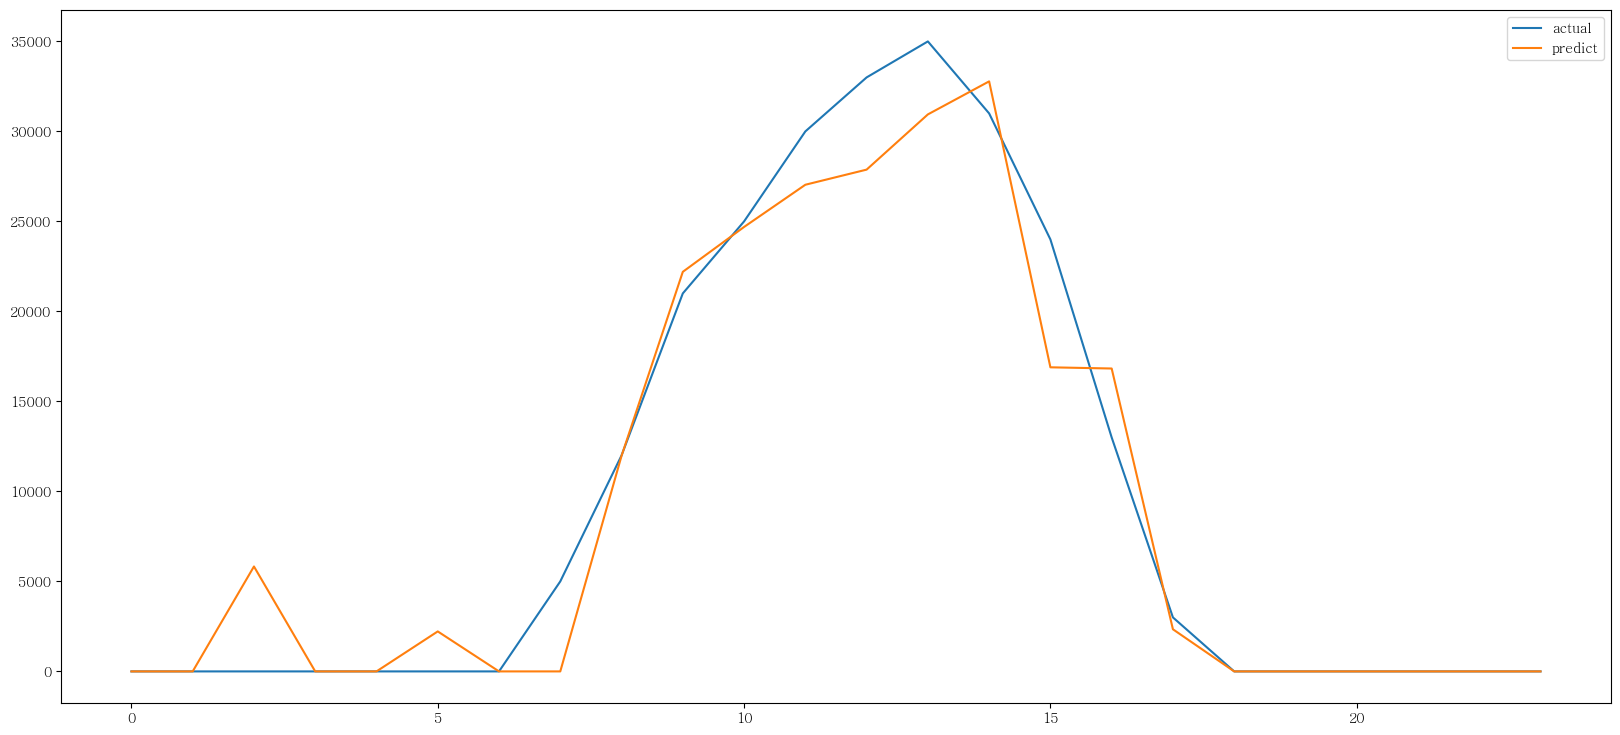

In [66]:
plt.figure(figsize=(20, 9))
plt.plot(result_data, label='actual')
plt.plot(pred_data, label='predict')
plt.legend()
plt.show()